# Project: Image Classification and Regression - Marion Favre d'Echallens

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.patches as patches
import keras

In [2]:
#Keras modules
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, Input, UpSampling2D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


Useful functions and example

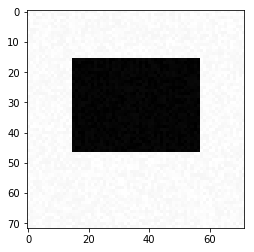

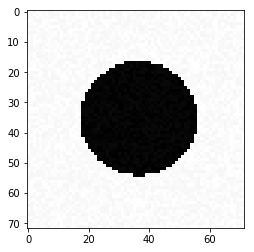

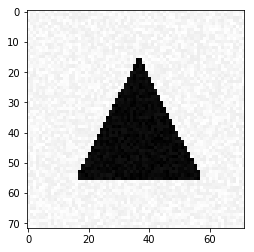

In [3]:
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


#### 3) SIMPLE CLASSIFICATION: RECTANGLE(0), DISK(1), TRIANGLE(2)

##### a) STOCHASTIC GRADIENT OPTIMIZER

In [6]:
[X_train, Y_train] = generate_dataset_classification(300, 20) 
# Convert labels to categorical one-hot encoding
Y_train = np_utils.to_categorical(Y_train, num_classes=3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [22]:
#Stochastic Gradient Descent 
# For a three-class classification problem
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(5184,)))
model.add(Dense(3, activation='softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=False)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,metrics=['accuracy']) 

#training the model  
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 1.8465 - acc: 0.3600
Epoch 2/10
300/300 [==============================] - 0s 500us/step - loss: 0.9237 - acc: 0.5667
Epoch 3/10
300/300 [==============================] - 0s 550us/step - loss: 0.7963 - acc: 0.6267
Epoch 4/10
300/300 [==============================] - 0s 626us/step - loss: 0.7677 - acc: 0.6333
Epoch 5/10
300/300 [==============================] - 0s 593us/step - loss: 0.6066 - acc: 0.7500
Epoch 6/10
300/300 [==============================] - 0s 563us/step - loss: 0.5235 - acc: 0.7600
Epoch 7/10
300/300 [==============================] - 0s 550us/step - loss: 0.4591 - acc: 0.7900
Epoch 8/10
300/300 [==============================] - 0s 566us/step - loss: 0.4824 - acc: 0.7867
Epoch 9/10
300/300 [==============================] - 0s 646us/step - loss: 0.4240 - acc: 0.7767
Epoch 10/10
300/300 [==============================] - 0s 546us/step - loss: 0.3491 - acc: 0.8700


In [23]:
#testing
X_test = generate_a_disk() #classe 1
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test,batch_size=32, verbose=0)

array([[0., 1., 0.]], dtype=float32)

##### B) ADAM OPTIMIZER

In [11]:
# For a three-class classification problem
model_A = Sequential()
model_A.add(Dense(3, activation='softmax',input_shape = (5184,)))
model_A.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy']) 
#training the model
model_A.fit(X_train, Y_train, epochs=10, batch_size=32)


Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 1.3235 - acc: 0.4600
Epoch 2/10
300/300 [==============================] - 0s 450us/step - loss: 0.7039 - acc: 0.6533
Epoch 3/10
300/300 [==============================] - 0s 363us/step - loss: 0.4856 - acc: 0.7667
Epoch 4/10
300/300 [==============================] - 0s 406us/step - loss: 0.3914 - acc: 0.8233
Epoch 5/10
300/300 [==============================] - 0s 433us/step - loss: 0.2960 - acc: 0.9300
Epoch 6/10
300/300 [==============================] - 0s 500us/step - loss: 0.2759 - acc: 0.9233
Epoch 7/10
300/300 [==============================] - 0s 736us/step - loss: 0.2948 - acc: 0.8667
Epoch 8/10
300/300 [==============================] - 0s 660us/step - loss: 0.2132 - acc: 0.9533
Epoch 9/10
300/300 [==============================] - 0s 526us/step - loss: 0.2317 - acc: 0.9167
Epoch 10/10
300/300 [==============================] - 0s 650us/step - loss: 0.2638 - acc: 0.8867 0s - loss: 0.2291 - acc: 0.906


In [24]:
#testing
X_test = generate_a_disk() #classe 1
X_test = X_test.reshape(1, X_test.shape[0])
model_A.predict(X_test,batch_size=32, verbose=0)

array([[0., 1., 0.]], dtype=float32)

Adam optimizer seems to have a better accurracy than the SGD optimizer.

### 4) VISUALIZATION OF THE SOLUTION

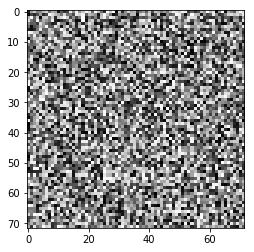

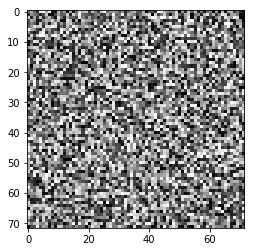

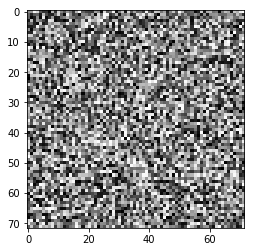

In [25]:
# SGD optimizer
W = model.layers[0].get_weights()
plt.imshow(W[0][:,0].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,1].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,2].reshape(72,72), cmap='gray')
plt.show()

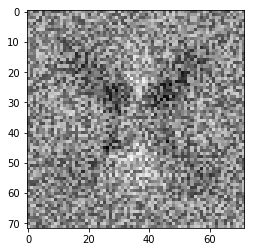

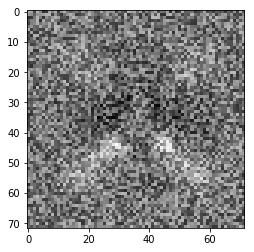

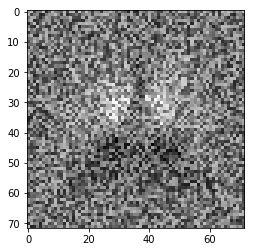

In [26]:
# Adam optimizer
W = model_A.layers[0].get_weights()
plt.imshow(W[0][:,0].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,1].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,2].reshape(72,72), cmap='gray')
plt.show()

### 5) MORE DIFFICULT CLASSIFICATION PROBLEM

In [10]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = np_utils.to_categorical(Y_train, num_classes=3)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [32]:
#Stochastic Gradient Descent 
# For a three-class classification problem
model = Sequential()
model.add(Dense(168, activation='relu', input_shape = (5184,)))
model.add(Dense(3, activation='softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.5, nesterov=False)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,metrics=['accuracy']) 

#training the model  
model.fit(X_train, Y_train, epochs=10, batch_size=64)

Epoch 1/10
300/300 [==============================] - 2s 5ms/step - loss: 4.0787 - acc: 0.3100
Epoch 2/10
300/300 [==============================] - 0s 2ms/step - loss: 1.1330 - acc: 0.3800
Epoch 3/10
300/300 [==============================] - 0s 1ms/step - loss: 1.0837 - acc: 0.3967
Epoch 4/10
300/300 [==============================] - 0s 693us/step - loss: 1.0811 - acc: 0.4000
Epoch 5/10
300/300 [==============================] - 0s 610us/step - loss: 1.0724 - acc: 0.4067
Epoch 6/10
300/300 [==============================] - 0s 520us/step - loss: 1.0702 - acc: 0.4867
Epoch 7/10
300/300 [==============================] - 0s 680us/step - loss: 1.0684 - acc: 0.3900
Epoch 8/10
300/300 [==============================] - 0s 476us/step - loss: 1.0551 - acc: 0.4033
Epoch 9/10
300/300 [==============================] - 0s 576us/step - loss: 1.0410 - acc: 0.4467
Epoch 10/10
300/300 [==============================] - 0s 510us/step - loss: 1.0160 - acc: 0.5367


In [11]:
[X_test, Y_test] = generate_test_set_classification()

#loss and accuracy
model.evaluate(X_test, Y_test) #SGD optimizer

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


NameError: name 'model' is not defined

In [34]:
# For a three-class classification problem
model_A = Sequential()
model_A.add(Dense(3, activation='softmax',input_shape = (5184,)))
model_A.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy']) 
#training the model
model_A.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 2.2492 - acc: 0.3567
Epoch 2/10
300/300 [==============================] - 0s 386us/step - loss: 1.6901 - acc: 0.3667
Epoch 3/10
300/300 [==============================] - 0s 280us/step - loss: 1.2031 - acc: 0.4600
Epoch 4/10
300/300 [==============================] - 0s 350us/step - loss: 1.0345 - acc: 0.4300
Epoch 5/10
300/300 [==============================] - 0s 297us/step - loss: 0.9575 - acc: 0.4800
Epoch 6/10
300/300 [==============================] - 0s 306us/step - loss: 0.9091 - acc: 0.5167
Epoch 7/10
300/300 [==============================] - 0s 340us/step - loss: 1.0132 - acc: 0.5067
Epoch 8/10
300/300 [==============================] - 0s 313us/step - loss: 1.0550 - acc: 0.4967
Epoch 9/10
300/300 [==============================] - 0s 380us/step - loss: 1.0967 - acc: 0.4733
Epoch 10/10
300/300 [==============================] - 0s 283us/step - loss: 1.0109 - acc: 0.5000


In [35]:
model_A.evaluate(X_test, Y_test) #Adam optimizer

300/300 [==============================] - 0s 923us/step


[1.2037010113398234, 0.4233333325386047]

Previous models are less efficient with the new training set, Adam optimizer remains better than SGD optimizer.

In [13]:
#creating a new model  
X_trainr=X_train.reshape(X_train.shape[0],72,72,1)
print(X_trainr.shape)
Y_trainr=Y_train
print(Y_trainr.shape)

(300, 72, 72, 1)
(300, 3)


In [21]:
##Convolution2D
model2 = Sequential() 
model2.add(Conv2D(16, (5,5), activation='relu',input_shape=(72,72,1)))
print(model2.output_shape)

model2.add(MaxPooling2D(pool_size =(2,2)))
print(model2.output_shape)
model2.add(Flatten())
print(model2.output_shape)
model2.add(Dense(3,activation='softmax'))
print(model2.output_shape)


model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model2.fit(X_trainr, Y_trainr, epochs=20, batch_size=32)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 18496)
(None, 3)
Epoch 1/20
300/300 [==============================] - 2s 7ms/step - loss: 1.3422 - acc: 0.3233
Epoch 2/20
300/300 [==============================] - 1s 3ms/step - loss: 1.0099 - acc: 0.4200
Epoch 3/20
300/300 [==============================] - 1s 4ms/step - loss: 0.8560 - acc: 0.7200
Epoch 4/20
300/300 [==============================] - 1s 5ms/step - loss: 0.7532 - acc: 0.7367
Epoch 5/20
300/300 [==============================] - 1s 4ms/step - loss: 0.6404 - acc: 0.7767
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.5654 - acc: 0.8100
Epoch 7/20
300/300 [==============================] - 1s 4ms/step - loss: 0.5413 - acc: 0.7967
Epoch 8/20
300/300 [==============================] - 1s 4ms/step - loss: 0.4710 - acc: 0.8667
Epoch 9/20
300/300 [==============================] - 1s 4ms/step - loss: 0.4419 - acc: 0.8667
Epoch 10/20
300/300 [==============================] - 1s 4ms/step - loss: 0.3893 -

In [19]:
X_testr = X_test.reshape(X_test.shape[0],72,72,1)
print(X_testr.shape)

(300, 72, 72, 1)


In [22]:
model2.evaluate(X_testr, Y_test)

300/300 [==============================] - 1s 3ms/step


[0.6228227814038595, 0.73]

The value of the lost function when using the deep network is: 0.64. 

### 6) A REGRESSION PROBLEM

In [4]:
#normalize vertices
def normer(Y):
    for i in range(len(Y)):
        a = math.sqrt(Y[i,0]**2 + Y[i,1]**2)
        b = math.sqrt(Y[i,2]**2 + Y[i,3]**2)
        c = math.sqrt(Y[i,4]**2 + Y[i,5]**2)
        Y[i,:]=[Y[i,0]/a,Y[i,1]/a,Y[i,2]/b,Y[i,3]/b,Y[i,4]/c,Y[i,5]/c]
    return Y


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


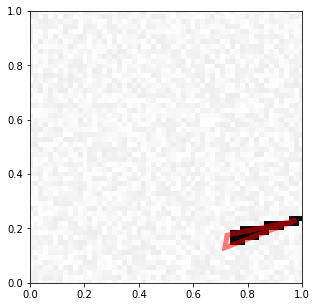

In [23]:
[X_train, Y_train] = generate_dataset_regression(300, 20)
visualize_prediction(X_train[0], Y_train[0])

In [24]:
X_train2 = X_train.reshape(X_train.shape[0], 72, 72, 1)
Y_train = normer(Y_train)

In [72]:
model_r = Sequential()     ## à améliorer
model_r.add(Conv2D(32, (5, 5), activation='relu', input_shape=(72, 72, 1)))
model_r.add(MaxPooling2D(pool_size=(2, 2)))

model_r.add(Conv2D(32, (5, 5), activation='relu', input_shape=(72, 72, 1)))
model_r.add(MaxPooling2D(pool_size=(2, 2)))
model_r.add(Flatten()) 
model_r.add(Dense(64, activation='relu')) 
#model_r.add(Dense(128, activation='relu')) 
model_r.add(Dense(6)) 

adam = Adam(lr=1e-3, beta_1=0.5, beta_2=0.6, epsilon=0.001, decay=0.1)
model_r.compile(loss='mean_squared_error', 
              optimizer=adam,metrics = ['accuracy'])
model_r.fit(X_train2, Y_train, epochs=20, batch_size=64)


Epoch 1/20
300/300 [==============================] - 6s 19ms/step - loss: 0.2575 - acc: 0.1733
Epoch 2/20
300/300 [==============================] - 4s 12ms/step - loss: 0.0844 - acc: 0.1967
Epoch 3/20
300/300 [==============================] - 4s 12ms/step - loss: 0.0827 - acc: 0.2000
Epoch 4/20
300/300 [==============================] - 4s 12ms/step - loss: 0.0794 - acc: 0.2133
Epoch 5/20
300/300 [==============================] - 4s 12ms/step - loss: 0.0788 - acc: 0.2833
Epoch 6/20
300/300 [==============================] - 4s 12ms/step - loss: 0.0759 - acc: 0.2900
Epoch 7/20
300/300 [==============================] - 3s 12ms/step - loss: 0.0743 - acc: 0.2533
Epoch 8/20
300/300 [==============================] - 3s 12ms/step - loss: 0.0731 - acc: 0.2933
Epoch 9/20
300/300 [==============================] - 3s 11ms/step - loss: 0.0717 - acc: 0.3300
Epoch 10/20
300/300 [==============================] - 3s 12ms/step - loss: 0.0700 - acc: 0.3200
Epoch 11/20
300/300 [==================

In [64]:
[X_test, Y_test] = generate_test_set_regression()
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [73]:
Y_test = normer(Y_test)
model_r.evaluate(X_test, Y_test)

300/300 [==============================] - 2s 7ms/step


[0.06812700510025024, 0.2966666668653488]

### 7) IMAGE DENOISING

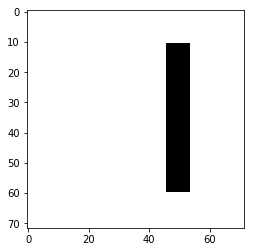

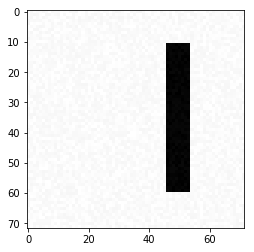

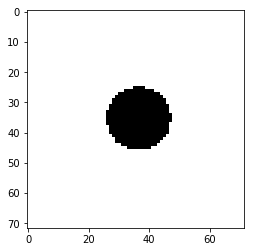

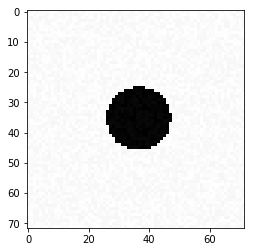

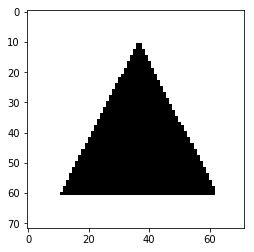

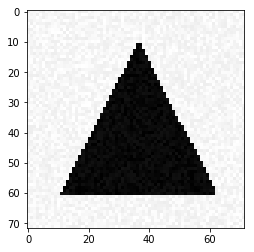

In [53]:
def generate_a_rectangle_pair(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise=0), generate_a_drawing(figsize, U, V, noise)


def generate_a_disk_pair(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise=0), generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle_pair(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata, imdata_noise = generate_a_drawing(figsize, U, V, noise=0),generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]],[imdata_noise, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im, im_noise = generate_a_rectangle_pair(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(im_noise.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

im, im_noise = generate_a_disk_pair(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(im_noise.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im, v], [im_noise,vv] = generate_a_triangle_pair(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
plt.imshow(im_noise.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification_pair(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    X_noise = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], X_noise[i] = generate_a_rectangle_pair(noise, free_location)
        elif category == 1: 
             X[i], X_noise[i] = generate_a_disk_pair(noise, free_location)
        else:
            [X[i], V],[X_noise[i], VV]= generate_a_triangle_pair(noise, free_location)
        Y[i] = category
    X = X / 255
    X_noise = (X_noise + noise) / (255 + 2 * noise)
    return [X, X_noise, Y]

In [54]:
X, X_noise, Y = generate_dataset_classification_pair(
    nb_samples=300, noise=50, free_location=True
)
X_noise = X_noise.reshape(X_noise.shape[0], 72, 72, 1)
X = X.reshape(X.shape[0], 72, 72, 1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [57]:
X_test, X_noise_test, Y_test = generate_dataset_classification_pair(
    nb_samples=150, noise=50, free_location=True
)
X_noise_test = X_noise_test.reshape(X_noise_test.shape[0], 72, 72, 1)
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [58]:
## building a convolutional autoencoder    à modifier??

input_img = Input(shape=(72, 72, 1))  # image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)



x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics = ['accuracy'])

In [59]:
from keras.callbacks import TensorBoard
autoencoder.fit(X_noise, X,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(X_noise_test, X_test)
               )

Train on 300 samples, validate on 150 samples
Epoch 1/10
300/300 [==============================] - 18s 60ms/step - loss: 0.1173 - acc: 0.9131 - val_loss: 0.0771 - val_acc: 0.9153
Epoch 2/10
300/300 [==============================] - 16s 54ms/step - loss: 0.0791 - acc: 0.9131 - val_loss: 0.0682 - val_acc: 0.9153
Epoch 3/10
300/300 [==============================] - 17s 56ms/step - loss: 0.0607 - acc: 0.9131 - val_loss: 0.0526 - val_acc: 0.9153
Epoch 4/10
300/300 [==============================] - 17s 56ms/step - loss: 0.0469 - acc: 0.9142 - val_loss: 0.0383 - val_acc: 0.9331
Epoch 5/10
300/300 [==============================] - 16s 54ms/step - loss: 0.0327 - acc: 0.9560 - val_loss: 0.0248 - val_acc: 0.9840
Epoch 6/10
300/300 [==============================] - 15s 50ms/step - loss: 0.0169 - acc: 0.9875 - val_loss: 0.0084 - val_acc: 0.9919
Epoch 7/10
300/300 [==============================] - 15s 49ms/step - loss: 0.0065 - acc: 0.9928 - val_loss: 0.0056 - val_acc: 0.9929
Epoch 8/10
300/3

(10, 72, 72, 1)


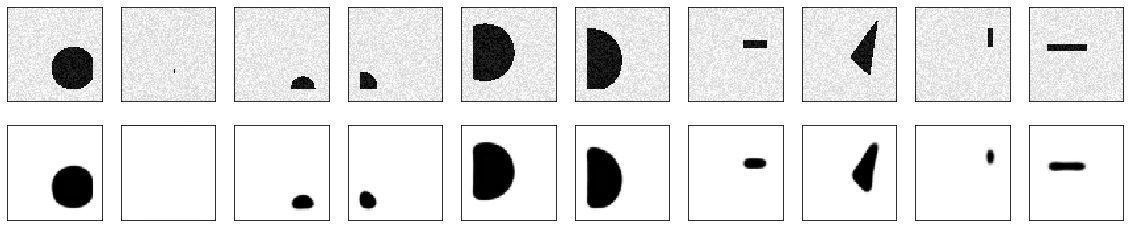

In [60]:
## Denoising result
n = 10
decoded_imgs = autoencoder.predict(X_noise_test[n:2*n])
print(decoded_imgs.shape)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_noise_test[i + n].reshape(72, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(72, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()